# Wielkoskalowe metody pomiarowe w biologii molekularnej
## Metody selekcji cech - 2. Selekcja genów lub białek o ekspresji różnicującej dwie grupy próbek przy użyciu metody Recursive Feature Elimination
### Bartosz Sowul, Katarzyna Szmulewicz

## test: instalacja potrzebnych modułów

In [1]:
%matplotlib inline
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scikit_learn

## test: ładowanie potrzebnych modułów

In [2]:
import pandas as pd

## Funkcja pomocnicza przygotowująca dane
### zbudowana na podstawie analizy wstępnej zbioru przeprowadzonej w analiza_wstepna.ipynb

In [3]:
def prepare_data(dataset, verbose=False):
    df = pd.read_csv(dataset, sep='\t')
    df = df.transpose()
    
    # print(f'Head:\n {df.head()}')
    
    #print(df.iloc[1:].head()) 
    #print(df.iloc[1:].describe())
    #print(df.iloc[1:][df.columns.difference(['class'])].head()) # same dane bez etykiety

    df.rename(columns={0: 'class'}, inplace=True) # zmienia nazwę 1 kolumny na class
    df1 = df.iloc[1:] # bez nazw kolumn
    # print(f'df1 bez nazw kolumn:\n {df1.head()}')

    class_num  = int(df1['class'].describe()['unique'])
    
    if verbose:
        print(df1['class'].describe())
        print(class_num)
    
    while class_num > 2:
        counts = df1['class'].value_counts()
        
        if verbose:
            print(f'class_num: {class_num}')
            print(f'counts:\n{counts}')
            print(f'counts.idx: {counts.idxmin()}')
            print(f'counts[counts.idxmin()]:\n{counts[counts.idxmin()]}')
            print(f'counts[counts > min(counts)]:\n{counts[counts > min(counts)]}')
            print()
        
        df1 = df1[df1['class'] != counts.idxmin()]
        class_num -= 1
    else:
        if verbose:
            print(f'ZOSTAŁY 2 KLASY:')
            print(f'class_num: {class_num}')
            print('counts:\n{}'.format(df1['class'].value_counts()))
            print(df1.shape)
            print(df1.isnull().values.any()) # sprawdza, czy dane są kompletne
            
        df1 = df1.apply(pd.to_numeric) # zmienia typy ze stringów na liczby
        X = df1.iloc[1:][df1.columns.difference([0])]
        y = df1.iloc[1:, 0]

        return X, y

## Ładowanie danych

In [4]:
DATA_PATH = './data'
DIRS = ['Leukemia', 'LungCancer', 'Lymphoma']
datasets_preprocessed = [d+'_preprocessed.txt' for d in DIRS]
datasets_500 = [d+'_500.txt' for d in DIRS]
datasets_preprocessed_paths = []
datasets_500_paths = []

print('Preparing datasets paths:')
for dataset_preprocessed, dataset_500, directory in zip(datasets_preprocessed, datasets_500, DIRS):
    datasets_preprocessed_paths.append(DATA_PATH + '/' + directory + '/' + dataset_preprocessed)
    datasets_500_paths.append(DATA_PATH + '/' + directory + '/' + dataset_500)
    print('\t- ',dataset_preprocessed,'->',datasets_preprocessed_paths[-1])
    print('\t- ',dataset_500,'->',datasets_500_paths[-1])
else:
    print('Paths created.\n')

XX = []
yy = []

for dataset_preprocessed_path, dataset_500_path in zip(datasets_preprocessed_paths, datasets_500_paths):
    print(f'Preparing {dataset_preprocessed_path}...')
    X, y = prepare_data(dataset_preprocessed_path)
    XX.append(X)
    yy.append(y)
    print(f'Preparing {dataset_500_path}...')
    X, y = prepare_data(dataset_500_path)
    XX.append(X)
    yy.append(y)
    print('Done.')
    print()
else:
    print('All datasets ready.')

Preparing datasets paths:
	-  Leukemia_preprocessed.txt -> ./data/Leukemia/Leukemia_preprocessed.txt
	-  Leukemia_500.txt -> ./data/Leukemia/Leukemia_500.txt
	-  LungCancer_preprocessed.txt -> ./data/LungCancer/LungCancer_preprocessed.txt
	-  LungCancer_500.txt -> ./data/LungCancer/LungCancer_500.txt
	-  Lymphoma_preprocessed.txt -> ./data/Lymphoma/Lymphoma_preprocessed.txt
	-  Lymphoma_500.txt -> ./data/Lymphoma/Lymphoma_500.txt
Paths created.

Preparing ./data/Leukemia/Leukemia_preprocessed.txt...
Preparing ./data/Leukemia/Leukemia_500.txt...
Done.

Preparing ./data/LungCancer/LungCancer_preprocessed.txt...
Preparing ./data/LungCancer/LungCancer_500.txt...
Done.

Preparing ./data/Lymphoma/Lymphoma_preprocessed.txt...
Preparing ./data/Lymphoma/Lymphoma_500.txt...
Done.

All datasets ready.


## Implementacja funkcji Recursive Feature Elimination

In [73]:
from math import floor
from time import time

import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC

ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(floor(n/10)%10!=1)*(n%10<4)*n%10::4])

def recursive_feature_elimination(X, y, verbose=0):
    
    n_features = X.shape[1]
    features_left = X.shape[1]
    features_eliminated = []
    cv_results = []
    
    ranking_dict = {i: 1 for i in range(n_features)}
    remaining = [True for i in range(n_features)]
    features = np.arange(n_features)[remaining]
    i = 0
    
    start = time()
    
    while features_left > 1:
        # Remaining features
        # array (0, n_features) with boolean masking
        # https://docs.scipy.org/doc/numpy-1.15.0/user/basics.indexing.html#boolean-or-mask-index-arrays
        features = np.arange(n_features)[remaining]
        
        # Create SVM model using a linear kernel
        clf = SVC(kernel='linear', gamma='auto')
        if verbose > 0:
            print(f'Fitting classifier with {features_left} features.')

        clf.fit(X[:, features], y)
        # Get cv score on remaining features
        cv_results.append(cross_val_score(clf, X[:, features], y,
                            scoring='accuracy', cv=StratifiedKFold(2)).mean())

        # Calc ranks
        ranks = clf.coef_ ** 2
        # Rank the remaining features
        ranks = np.argsort(ranks.sum(axis=0))
        # argsort sorts asc, sum over columns
        # axis 0: the first running vertically downwards across rows,
        # axis 1: the second running horizontally across columns.
        # https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.argsort.html
        
        features_eliminated.append(features[ranks][0])
        ranking_dict[features[ranks][0]] = features_left

        # Eliminate the worst feature
        remaining[features[ranks][0]] = False
        features_left -= 1
        i += 1
        
        if verbose > 0:
            print('features ranked from worst to best:\n', ranks)
            print(f'worst feature at {ordinal(i)} iter:\n', features[ranks][0])
            print('features eliminated so far:\n', features_eliminated)
            print('features left:\n', np.arange(n_features)[remaining])
            print('ranking:\n', ranking_dict)
            if verbose == 2:
                input('Press Enter to continue....\n')
    else:
        final_ranking = list(ranking_dict.items())
        if sum(range(1, n_features+1)) == sum(rank for feature, rank in final_ranking):
            print(f'\nRFECV took {time() - start:.2f} seconds.')
            print('\nfinal ranking:\n', final_ranking)
            print('\nranking:\n', ranking_dict)
            return final_ranking, ranking_dict, list(reversed(cv_results))
        else:
            print("Something's wrong...")

## test: recursive_feature_elimination na zbiorze digits

In [75]:
from operator import itemgetter

from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

final_ranking, ranking_dict, cv_results = recursive_feature_elimination(X, y, verbose=0)

# best is 30, worst is 0
print()
print(f'cv_results (from using 1 feature to using all of them):\n{cv_results}')
print()
print(f'ranking_sorted (from best to worst):\n{sorted(final_ranking, key=itemgetter(1))}')


RFECV took 10.92 seconds.

final ranking:
 [(0, 64), (1, 50), (2, 31), (3, 23), (4, 10), (5, 17), (6, 34), (7, 51), (8, 57), (9, 37), (10, 30), (11, 43), (12, 14), (13, 32), (14, 44), (15, 52), (16, 54), (17, 41), (18, 19), (19, 15), (20, 28), (21, 8), (22, 39), (23, 53), (24, 55), (25, 45), (26, 9), (27, 18), (28, 20), (29, 38), (30, 1), (31, 59), (32, 63), (33, 42), (34, 25), (35, 35), (36, 29), (37, 16), (38, 2), (39, 62), (40, 61), (41, 40), (42, 5), (43, 11), (44, 13), (45, 6), (46, 4), (47, 58), (48, 56), (49, 47), (50, 26), (51, 36), (52, 24), (53, 3), (54, 22), (55, 48), (56, 60), (57, 49), (58, 7), (59, 27), (60, 33), (61, 21), (62, 12), (63, 46)]

ranking:
 {0: 64, 1: 50, 2: 31, 3: 23, 4: 10, 5: 17, 6: 34, 7: 51, 8: 57, 9: 37, 10: 30, 11: 43, 12: 14, 13: 32, 14: 44, 15: 52, 16: 54, 17: 41, 18: 19, 19: 15, 20: 28, 21: 8, 22: 39, 23: 53, 24: 55, 25: 45, 26: 9, 27: 18, 28: 20, 29: 38, 30: 1, 31: 59, 32: 63, 33: 42, 34: 25, 35: 35, 36: 29, 37: 16, 38: 2, 39: 62, 40: 61, 41: 40, 

## Funkcja pomocnicza do robienia wykresów

In [151]:
def plot(cv_results, cutoff=-1, figsize=[20, 10]):
    plt.rcParams['figure.figsize'] = figsize
    plt.figure()
    plt.xlabel('Liczba wybranych cech')
    plt.ylabel('Średnia wartość metryki accuracy dla 2-Fold CV')
    if cutoff > 0:
        cutoff = int(cutoff)
        plt.plot(range(1, len(cv_results[:cutoff+1]) + 1), cv_results[:cutoff+1])
        print(f'Accuracy using {cutoff} features is {cv_results[cutoff]}.')
    else:
        plt.plot(range(1, len(cv_results) + 1), cv_results)
        index, value = max(enumerate(cv_results), key=itemgetter(1))
        print(f'Best accuracy is {value} using {index+1} features.')
    plt.show()

## test: robienie wykresów do wyników rfe na zbiorze digits

Best accuracy is 0.9438211015538291 using 31 features.


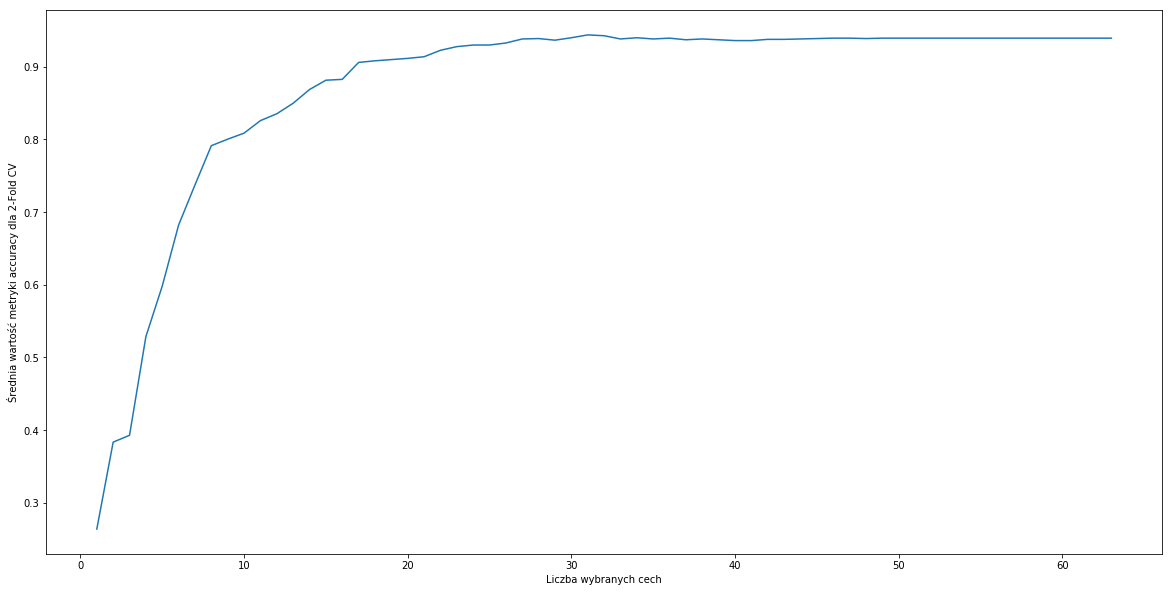

Accuracy using 25 features is 0.9326758710559695.


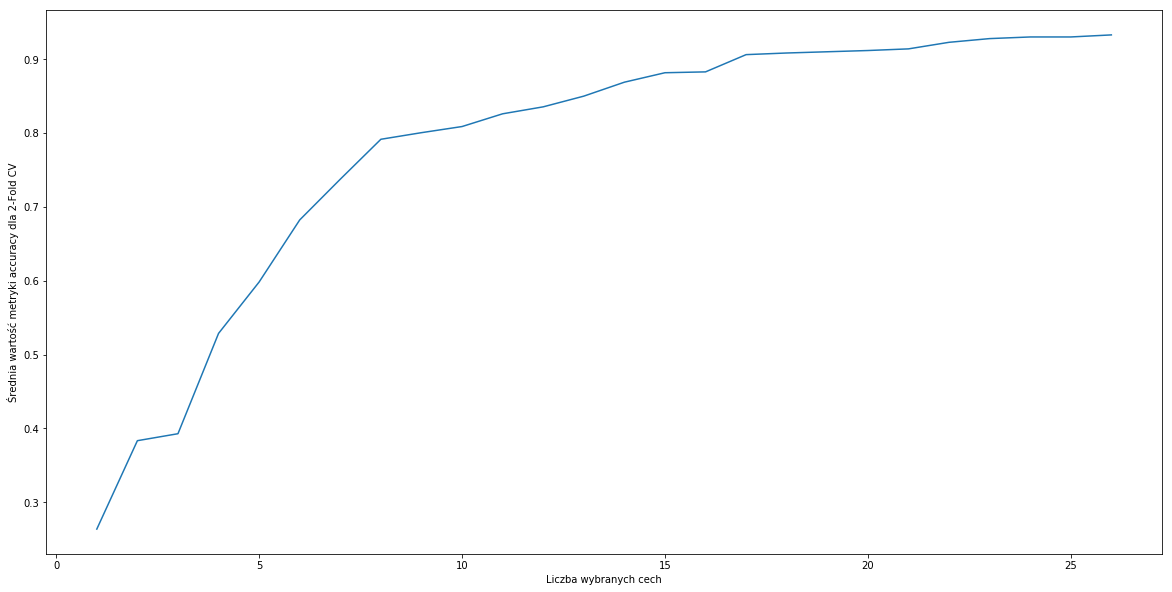

In [143]:
plot(cv_results)    
plot(cv_results, cutoff=25)

## Eksperymenty na wybranych zbiorach